## Introduction
----

This Tutorial will give you an example of how to compute Least Squares and Recursive Least Squares.

We will be using numpy for matrix computation and matplotlib for visualization.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## Model and data
----

The example of resistance measurement in the slides is an estimation of a single constant. In this code, we will extend the example to estimate a vector $\mathbf{x}$ with length of 2.

You will be fitting a linear model between voltage and current: $V = RI + b$. You are given the measurements of voltage $V$ and current $I$, while your goal is to estimate the value of resistance $R$ and offset $b$. If Ohm's law ($V = RI$) holds, you expect this offset $b$ to be near zero.

The measurements you get is in the following table:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

How good are these measurements? You may assume that the current values are known exactly, and that the voltage measurements are corrupted by additive, independent and identitically distributed zero-mean Gaussian noise with a standard deviation of $0.15~V$ (i.e., a variance of $0.0225 ~ V^2$). You may also assume that your initial estimates for $\hat{R}$ and $\hat{b}$ are uncorelated (i.e., the off-diagonal elements of the $2 \times 2$ covariance matrix are zero). 

In [2]:
I = np.array([[0.2, 0.3, 0.4, 0.5, 0.6]]).T
V = np.array([[1.23, 1.38, 2.06, 2.47, 3.17]]).T

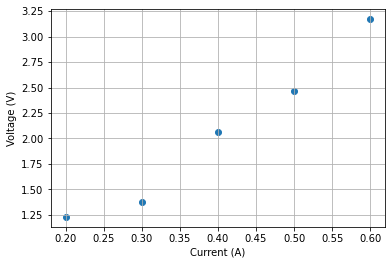

In [3]:
plt.scatter(I, V)
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()

## Task 1: Least Squares
----

Let's first suppose you got all the measurements at once. In this case, you can use least squares to estimate the results.

As you may find in the slides, the equation to be used for this estimation is:

\begin{align}
\hat{\mathbf{x}}_{LS} = \left(\mathbf{H}^T\mathbf{H}\right)^{-1}\mathbf{H}^T\mathbf{y}
\end{align}

All you need to do is to appropriately define $\mathbf{x}$, $\mathbf{H}$ and $\mathbf{y}$.

In [ ]:
# Least Squares Estimation
H = #TODO
x_ls = #TODO
print('The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:')
print('Estimates value for R is:', x_ls[0, 0])
print('Estimates value for b is:', x_ls[1, 0])

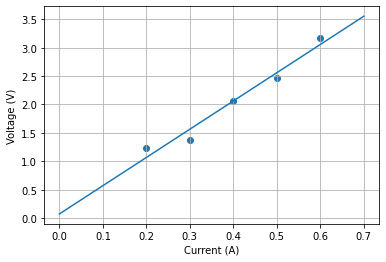

In [5]:
# Visualize results
I_line = np.arange(0, 0.8, 0.1).reshape(8, 1)
V_line = x_ls[0]*I_line + x_ls[1]

plt.scatter(I, V)
plt.plot(I_line, V_line)
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()

As expected, the offset parameter $\hat{b}$ is near zero, while $\hat{R}$ closely approximates the true resistance value of $R = 5~\Omega$.

## Task 2: Recursive Least Squares
----

Next, let's assume you don't get all measurements at once, but you get one set of $[V, I]$ measurements at a time, and you need to update your estimation of $[R, b]$ every time you get a new measurements.

In this case, you will need to use Recursive Least Square.

### Initialize
----

To use the recursive least squares formulation, you must have a prior estimate of the resistance and its associated uncertainty (otherwise, you won't know how to weigh the information you receive from a new measurement). You choose to set the initial parameters under the assumption that your prior estimate of the resistance, $R = 4$, is not very good. Also, since you are fairly sure that Ohm's law ($V = RI$) does, in fact, hold, you feel that it is safe to assume with high confidence that the offset term $b$ is close to zero. After some thought, you choose to intialize the recursive estimator as follows:

$$\hat{R} \sim \mathcal{N}(4, 9.0),~~\hat{b} \sim \mathcal{N}(0, 0.2)$$

Your initial guess is that $\hat{R}$ follows a Gaussian or normal distribution (recall that you do not know the exact value of $R$, so it must be considered as a random variable) with a mean of $4~\Omega$ and a standard deviation of $3~ \Omega$ (i.e., a variance of $9~\Omega^{2}$). Similarly, your intial guess is that $\hat{b}$ should also follow a normal distribution with a mean of $0~V$ and a variance of $0.2~V^{2}$.

With this initial guess, you can initiate the recursive least square.

**Initialize the parameter and covariance estimates**:

----
$$
\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right],\quad \mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]
$$

In [ ]:
# Initialize the 2x1 parameter vector x (i.e., x_0).
# In this specific case, our x is [R, b]
x_k = #TODO

#Initialize the 2x2 covaraince matrix (i.e. P_0). Off-diangonal elements should be zero.
P_k = #TODO

# Our voltage measurement variance (denoted by R, don't confuse with resistance).
R_k = #TODO

### Recursive Updates

After initialization, you can code the loop that updates your estimation with each new measurement.

**For every measurement k**:

----
  * Calculate the gain term: $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Update the parameter estimate: $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Update the covariance estimate: $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$
  
In this case, the initial parameter vector $\hat{\mathbf{x}}_0$ should contain $\hat{R}$ and $\hat{b}$. 

In [ ]:
# Pre allocate space to save our estimates at every step.
num_meas = I.shape[0]
x_hist = np.zeros((num_meas + 1, 2))
P_hist = np.zeros((num_meas + 1, 2, 2))

x_hist[0] = x_k.T[0]
P_hist[0] = P_k

# Iterate over all the available measurements.
for k in range(num_meas):

    # Construct H_k (Jacobian).
    H_k = #TODO

    # Construct K_k (gain matrix).
    K_k = #TODO
    
    # Get the new data
    y_k = #TODO
                    
    # Update our estimate.
    x_k = #TODO
 
    # Update our uncertainty (covariance)
    P_k = #TODO

    # Keep track of our history.
    P_hist[k + 1] = P_k
    x_hist[k + 1] = x_k.T[0]
    
print('The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:')
print('Estimates value for R is:', x_k[0, 0])
print('Estimates value for b is:', x_k[1, 0])

### Plotting the Results
----
Let's plot out the solution at each step. Does the resistance value converge towards the batch least squares solution?

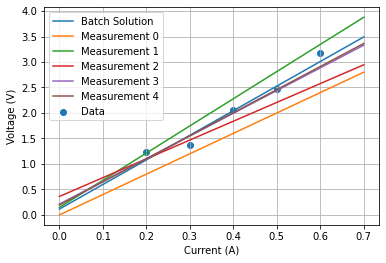

In [16]:
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1).reshape(8, 1)

for k in range(num_meas):
    V_line = x_hist[k, 0]*I_line + x_hist[k, 1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))

plt.legend()
plt.show()

The resistance estimate $\hat{R}$ should approach the true resistance value of $R = 5~\Omega$ very closely (i.e., to within a few hundredths of ohms). As expected, the offset term $\hat{b}$ should be small as well (less than 0.1 ohms). Try modifying the initialization (e.g., the intial uncertainty of the prior guess) - can you get a better final esimate?